In [1]:
%%capture

%run ML_Record_Mining_JN.ipynb

In [2]:
# Loading libraries for modeling
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords

import time

import os
path = r'/Users/seiryu8808/Desktop/UWinsc/Github/UnacquiredSites/src/output'

# Options
pd.options.mode.chained_assignment = None

## Simple Modeling for Sitenames

First, we need to encode the text data into vectors in order to apply a Classification algorithm.

In [3]:
data = nlp_bib_neotoma[['_gddid', 'sentid', 'words', 'words_as_string', 'sitenames_l', 'intersection_words_sitenames']]

In [4]:
stop = ['lake','bog', 'laguna', 'pond', 'lago']
data['intersection_words_sitenames'] = data['intersection_words_sitenames'].apply(lambda x: [item for item in x if item not in stop])

In [5]:
stop_words = stopwords.words('english')
other_stop_words = 'lake',',' 'bog', 'laguna', 'pond', 'lago', "'d", "'ll", "'re", "'s", "'ve", 'could', 'might', 'must', "n't", 'need', 'sha', 'wo', 'would'

for i in other_stop_words:
    stop_words.append(i)

In [6]:
data['has_sitename'] = data['intersection_words_sitenames'].apply(len) != 0
# Map True to One and False to Zero
data['has_sitename'] = data['has_sitename'].astype(int)

# Reduce data to columns of interest for this task.
data = data[['words_as_string', 'has_sitename']]

# Define corpus for CountVectorizer
corpus = data['words_as_string'].tolist()

# Split data into training and testing sets
data_train, data_test = train_test_split(data, test_size = 0.20, random_state = 12)

# Translate words to vectors
# This model can add stopwords, punctuation, etc.
# For now, use all words.
vec = CountVectorizer(min_df=2, 
                      stop_words= stop_words,
                      tokenizer=nltk.word_tokenize)

# Fit and transform training
X_train = vec.fit_transform(data_train['words_as_string']) 
y_train = data_train['has_sitename']

# Transform test data without fitting
X_test = vec.transform(data_test['words_as_string']) 
y_test = data_test['has_sitename']

/Users/seiryu8808/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens [',', 'bog'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Let's try to fit into different models to see which one renders the best performance. Take into consideration that this model will eventually be escalated to a bigger amount of data.

In [7]:
classifiers = {
    'knn'           : KNeighborsClassifier(),
    'decision tree' : DecisionTreeClassifier(random_state = 0, max_depth = 15),
    'random forest' : RandomForestClassifier(n_estimators = 10)
#    'SVM'           : SVC(C = 100, gamma = "scale"),
#    'logistic reg'  : LogisticRegression(solver="lbfgs", max_iter = 10000)
}

In [8]:
def create_scores(classifiers = classifiers, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):
    train_scores = dict()
    test_scores = dict()
    training_times = dict()

    for classifier_name, classifier_obj in classifiers.items():
     #   print("Fitting", classifier_name)
        t = time.time()
        classifier_obj.fit(X_train, y_train)

        training_times[classifier_name] = time.time() - t
        train_scores[classifier_name] = classifier_obj.score(X_train, y_train)
        test_scores[classifier_name] = classifier_obj.score(X_test, y_test)

    data = {"train acc": train_scores, "valid acc" : test_scores, "training time (s)" : training_times}
    df = pd.DataFrame(data, columns = data.keys())
    df.index = list(classifiers.keys())
    return df

In [9]:
scores_df = create_scores()
scores_df

,train acc,valid acc,training time (s)
knn,0.923727,0.911009,0.027016
decision tree,0.932682,0.926997,2.085489
random forest,0.993588,0.943830,27.213608


We can see there is overfitting happening, since all testing scores are too good to be true.   
We also have to take into consideration that just 230 sentences have both coordinates out of over 100,000.   
With this data unbalance, guessing 0 over all sentences would still be a very high accuracy.

## Checking different scores such as confusion matrices

From the above matrix, we can see that SVM and Logistic Regression are computationally expensive. Taking into consideration that this experiment will eventually be scaled to a larger data set, let's discard these two methods. 

One way to know if a method is not missclassifying items, would be to check the confusion matrix and see how many false possitives or false negatives it has.

In [10]:
for classifier_name, classifier_obj in classifiers.items():
    print("Confusion Matrix", classifier_name)
    classifier_obj.fit(X_train, y_train)
    y_pred = classifier_obj.predict(X_test)
    conf_mat = confusion_matrix(y_test, y_pred).ravel()
    print(conf_mat)

Confusion Matrix knn
[19362   118  1780    68]
Confusion Matrix decision tree
[19425    55  1502   346]
Confusion Matrix random forest
[19399    81  1074   774]


Although KNN has less false positives, it has 11 more false negatives. True positives are being completely missed. 
So, although it is faster to train, it is not a good model.

Let's then work with Decission Tree classifier and tune it to find the best parameters.

In [11]:
min_samples_split_dict = {'sample_size':[], 'train_accuracy':[], 'test_accuracy' :[]}

for nsamples in range(2,200,20):
    model = DecisionTreeClassifier(min_samples_split = nsamples)
    model.fit(X_train, y_train)
    score = model.score(X_train,y_train)
    test_score = model.score(X_test,y_test)
    min_samples_split_dict['sample_size'].append(nsamples)    
    min_samples_split_dict['train_accuracy'].append(score)
    min_samples_split_dict['test_accuracy'].append(test_score)
    
min_samples_split_df = pd.DataFrame(min_samples_split_dict)
min_samples_split_df

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/seiryu8808/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-8f67d708e5c7>", line 5, in <module>
    model.fit(X_train, y_train)
  File "/Users/seiryu8808/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py", line 816, in fit
    X_idx_sorted=X_idx_sorted)
  File "/Users/seiryu8808/opt/anaconda3/lib/python3.7/site-packages/sklearn/tree/tree.py", line 380, in fit
    builder.build(self.tree_, X, y, sample_weight, X_idx_sorted)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/seiryu8808/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2040, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_render_traceback_'

During

KeyboardInterrupt: 

In [34]:
max_depth_dict = {'max_depth':[], 'train_accuracy':[], 'test_accuracy':[]}

for nsamples in range(100,200,10):
    model = DecisionTreeClassifier(max_depth = nsamples)
    model.fit(X_train, y_train)
    score = model.score(X_train,y_train)
    test_sc = model.score(X_test, y_test)
    max_depth_dict['max_depth'].append(nsamples)    
    max_depth_dict['train_accuracy'].append(score)
    max_depth_dict['test_accuracy'].append(test_sc)
    
max_depth_df = pd.DataFrame(max_depth_dict)
max_depth_df

,max_depth,train_accuracy,test_accuracy
0,100,0.959138,0.925638
1,110,0.961940,0.926622
2,120,0.964120,0.926341
3,130,0.966277,0.928029
4,140,0.968527,0.929717
5,150,0.970778,0.929060
6,160,0.973368,0.929107
7,170,0.973638,0.929904
8,180,0.975889,0.928263
9,190,0.977108,0.929717


In [12]:
clf = DecisionTreeClassifier(min_samples_split = 20, max_depth = 140)

In [13]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=140,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Having chosen our hyperparameters, let's examine which features are the most important features.

In [14]:
# See which features are considered important
f_imp = clf.feature_importances_

feature_importance = 100.0 * (f_imp / f_imp.max())
feature_names = vec.get_feature_names()

In [15]:
# A holder for feature_name: feature_importance
feats = {} 
for feature, importance in zip(feature_names, feature_importance):
    feats[feature] = importance #add the name/value pair

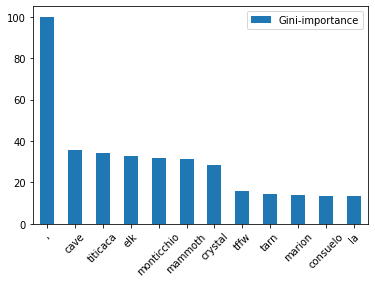

In [16]:
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance', ascending=False)[:12].plot(kind='bar', rot=45)

In [17]:
importances.sort_values(by='Gini-importance', ascending=False)[:12]

,Gini-importance
",",100.000000
cave,35.558367
titicaca,34.039348
elk,32.790262
monticchio,31.630167
...,...
tffw,16.022175
tarn,14.197256
marion,13.786596
consuelo,13.308742


In [18]:
y_pred = clf.predict(X_test)

In [19]:
clf.score(X_test, y_test)

0.954472993248312

In [20]:
confusion_matrix(y_test, y_pred).ravel()

array([19269,   211,   760,  1088])

After removing certain stopwords and tuning hyperparameters, the model improves.

TODO:  
 Take away vocabulary such as lake, bog, lago, pond.

In [22]:
# Export csv to compare y_pred and y_test labels
guessed_label = pd.DataFrame(y_pred)
actual_label = pd.DataFrame(y_test)
actual_label = actual_label.reset_index()

# Join with sentences
original_sentence = pd.DataFrame(data_test['words_as_string'])
original_sentence = original_sentence .reset_index()

comparison_df = guessed_label.join(actual_label)
comparison_df = comparison_df.drop(columns=['index'])

comparison_df = comparison_df.join(original_sentence)
comparison_df = comparison_df.drop(columns=['index'])

In [23]:
output_file = os.path.join(path,'modeled_sentences_sitenames.tsv')
comparison_df.to_csv(output_file, sep='\t', index = False)

One of the reasons for such a poor classification with the False Negatives, it is because data  is too unbalanced. 

We are going to address that problem now.

### Balancing DataSet

Although usually more data is better, we have a very few number of sentences that satisfy the condition of having "coordinates".

In order to balance training, I will only take 300 random sentences that have no coordinates. This will be even with sentences that have coordinates and maybe this will create less noise. 

In [21]:
data = nlp_bib_neotoma[['_gddid', 'sentid', 'words', 'words_as_string', 'sitenames_l', 'intersection_words_sitenames']]

In [22]:
data['has_sitename'] = data['intersection_words_sitenames'].apply(len) != 0
# Map True to One and False to Zero
data['has_sitename'] = data['has_sitename'].astype(int)

In [23]:
# Reduce data to columns of interest
data = data[['words_as_string', 'has_sitename']]

In [24]:
from random import shuffle
data0 = data[data['has_sitename'] == 0]
data0 = data0.sample(n = 12000)
data1 = data[data['has_sitename'] == 1]
data = pd.concat([data0, data1])
data.head(2)

,words_as_string,has_sitename
47380,"Woods,,,K.D.,,,Davis,,,M.B.,,,1989,.",0
46330,"Holocene,history,of,the,mangrove,islands,of,Tw...",0


In [25]:
# Define corpus for CountVectorizer
corpus = data['words_as_string'].tolist()

# Split data into training and testing sets
data_train, data_test = train_test_split(data, test_size = 0.20, random_state = 12)

In [26]:
# Translate words to vectors
# This model can add stopwords, punctuation, etc.
# For now, use all words.
vec = CountVectorizer(min_df=2,
                      stop_words= stop_words,
                      tokenizer=nltk.word_tokenize)

# Fit and transform training
X_train = vec.fit_transform(data_train['words_as_string']) 
y_train = data_train['has_sitename']

# Transform test data without fitting
X_test = vec.transform(data_test['words_as_string']) 
y_test = data_test['has_sitename']

/Users/seiryu8808/opt/anaconda3/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens [',', 'bog'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


Using same model since we are just comparing 'Data Balancing'

In [27]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=140,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=20,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [28]:
clf.score(X_test, y_test)

0.7406783231514641

In [29]:
clf.score(X_train, y_train)

0.9197260995522781

In [30]:
# See which features are considered important
f_imp = clf.feature_importances_
feature_importance = 100.0 * (f_imp / f_imp.max())
feature_names = vec.get_feature_names()

In [31]:
# A holder for feature_name: feature_importance
feats = {} 
for feature, importance in zip(feature_names, feature_importance):
    feats[feature] = importance #add the name/value pair

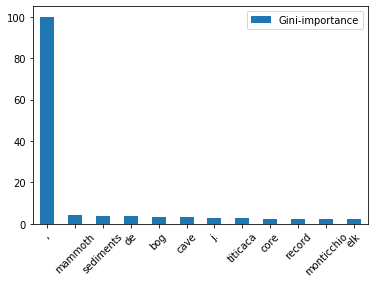

In [32]:
importances = pd.DataFrame.from_dict(feats, orient='index').rename(columns={0: 'Gini-importance'})
importances.sort_values(by='Gini-importance', ascending=False)[:12].plot(kind='bar', rot=45)

In [33]:
importances.sort_values(by='Gini-importance', ascending = False)[:15]

,Gini-importance
",",100.000000
mammoth,4.240384
sediments,3.996306
de,3.748091
bog,3.417228
...,...
monticchio,2.321373
elk,2.273036
basin,2.236446
site,2.065800


In [34]:
y_pred = clf.predict(X_test)
confusion_matrix(y_test, y_pred).ravel()

array([1883,  544,  687, 1633])

In [64]:
guessed_label = pd.DataFrame(y_pred)
actual_label = pd.DataFrame(y_test)
actual_label = actual_label.reset_index()

In [65]:
original_sentence = pd.DataFrame(data_test['words_as_string'])
original_sentence = original_sentence .reset_index()

In [66]:
site_comparison_df_sm = guessed_label.join(actual_label)
site_comparison_df_sm = site_comparison_df_sm.drop(columns=['index'])

In [67]:
site_comparison_df_sm = site_comparison_df_sm.join(original_sentence)
site_comparison_df_sm = site_comparison_df_sm.drop(columns=['index'])
site_comparison_df_sm

,0,has_sitename,words_as_string
0,0,0,"The,R-value,diagram,-LRB-,Fig.,10,-RRB-,proved..."
1,1,0,"An,abrupt,decline,of,about,50,‰,was,followed,b..."
2,0,0,"Abstracts,American,Quaternary,Association,1982..."
3,0,0,"American,Journal,of,Science,,,256,,,341-359,."
4,0,0,"This,paper,beneﬁtted,from,the,comments,of,M.,G..."
...,...,...,...
4742,0,0,"Schnitker,,,D.,&,Jorgensen,,,J.,-LRB-,1990,-RR..."
4743,1,1,"Age-depth,models,for,the,Minden,Bog,and,Hole,B..."
4744,0,1,"The,cores,from,Roque,Island,and,Schoodic,Penin..."
4745,0,0,"J.,Paleolimnol.,,,19,,,417,--,427,."


In [70]:
import os
output_file = os.path.join(path,'small_modelled_site_sentences.tsv')
site_comparison_df_sm.to_csv(output_file, sep='\t', index = False)